In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import networkx as nx

plt.style.use('ggplot') 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.simplefilter('ignore')

In [2]:
nodes = pd.read_csv(r'C:\Users\Meetali Tomer\Downloads\asoiaf-master\data\asoiaf-all-nodes.csv')
nodes = nodes['Id']
num_nodes = nodes.shape[0]

In [3]:
nodes

0                        Addam-Marbrand
1           Aegon-Frey-(son-of-Stevron)
2                     Aegon-I-Targaryen
3      Aegon-Targaryen-(son-of-Rhaegar)
4                     Aegon-V-Targaryen
                     ...               
791                         Yorko-Terys
792                              Ysilla
793                   Yurkhaz-zo-Yunzak
794                                 Zei
795                               Zollo
Name: Id, Length: 796, dtype: object

In [4]:
edges = pd.read_csv(r'C:\Users\Meetali Tomer\Downloads\asoiaf-master\data\asoiaf-all-edges.csv' )

In [5]:
edges

,Source,Target,Type,id,weight
0,Addam-Marbrand,Brynden-Tully,Undirected,0,3
1,Addam-Marbrand,Cersei-Lannister,Undirected,1,3
2,Addam-Marbrand,Gyles-Rosby,Undirected,2,3
3,Addam-Marbrand,Jaime-Lannister,Undirected,3,14
4,Addam-Marbrand,Jalabhar-Xho,Undirected,4,3
...,...,...,...,...,...
2818,Walder-Frey-(son-of-Merrett),Wex-Pyke,Undirected,2818,4
2819,Waymar-Royce,Will-(prologue),Undirected,2819,18
2820,Weasel,Weese,Undirected,2820,6
2821,Woth,Yoren,Undirected,2821,4


In [6]:
from graphviz import Digraph
dot = Digraph(comment='graph')
for i in range(num_nodes):
    dot.node(nodes[i])
for i in range(len(edges)):
    edge = edges.iloc[i]
    dot.edge(edge['Source'], edge['Target'])
dot.render('graph.gv', view=True)

'graph.gv.pdf'

In [7]:
edges = edges[edges.Target != 'Nan']
edges = edges[edges.Source != 'Nan']

In [8]:
edges.reset_index(drop=True,inplace=True)

In [11]:
nodes = pd.read_csv(r'C:\Users\Meetali Tomer\Downloads\asoiaf-master\data\asoiaf-all-nodes.csv')
labels = [i for i in range(len(nodes.Id))]
nodes['Id_Code'] = nodes.index

In [12]:
got_dict = dict(zip(nodes.Id,labels))

In [13]:
edges.drop(['Type','id'],axis=1,inplace=True)

In [14]:
edges['Source_Code'] = edges['Source'].apply(lambda x: got_dict[x])
edges['Target_Code'] = edges['Target'].apply(lambda x: got_dict[x])

In [15]:
edges[(edges.Source == 'Jon-Snow')].sort_values(by='weight', ascending=False).head()

,Source,Target,weight,Source_Code,Target_Code
2025,Jon-Snow,Samwell-Tarly,228,360,631
2003,Jon-Snow,Mance-Rayder,112,360,439
2020,Jon-Snow,Robb-Stark,91,360,600
2033,Jon-Snow,Stannis-Baratheon,91,360,667
2050,Jon-Snow,Ygritte,80,360,788


In [16]:
edge_tuples= []
for i in range(0,len(edges.index)):
    edge_tuples.append((edges.Source_Code[i],edges.Target_Code[i]))

In [17]:
def tuple_extractor_edge(df):
    tuple_out = []
    for i in range(0,len(df.index)):
        tuple_out.append((df['Source_Code'][i],df['Target_Code'][i]))
    return tuple_out

In [18]:
def tuple_extractor_edge_weight(df):
    tuple_out = []
    for i in range(0,len(df.index)):
        tuple_out.append((df['Source_Code'][i],df['Target_Code'][i],df['weight'][i]))
    return tuple_out

In [19]:
G=nx.Graph()

In [20]:
G.add_nodes_from(nodes.Id_Code)

In [21]:
for i in edge_tuples:
    G.add_edge(i[0],i[1])

In [22]:
got_nodes = pd.DataFrame({'Id':nodes.Id_Code,'Character':list(got_dict.keys()),
              'Degree':list(dict(G.degree).values()),
              'Centrality':list(dict(nx.betweenness_centrality(G)).values()),
             })

In [23]:
key_houses = ['Lannister','Targaryen','Baratheon','Tully',
                'Martell','Stark','Jon-Snow','Tarly','Greyjoy','Arryn',
                'Bolton','Frey','Cassel','Clegane','Selmy','Tyrell'
             ]
def house_label(i):
    for x in key_houses:
        if house(i,x):
            return x
    else: 
        return

In [24]:
import regex as re
def house(x,house):
    if re.search(f'^(?!.*details\.cfm).*{house}.*$',x):
        return True
    else:
        return False

In [25]:
got_nodes['House'] = got_nodes.Character.apply(lambda x: house_label(x))

In [26]:
got_edges = edges.copy()

In [27]:
got_dict_degree = dict(zip(list(got_nodes.Character),list(got_nodes.Degree)))

In [28]:
got_edges['Source_Degree'] = got_edges.Source.apply(lambda x: got_dict_degree[x])
got_edges['Target_Degree'] = got_edges.Target.apply(lambda x: got_dict_degree[x])

In [29]:
got_edges.head()

,Source,Target,weight,Source_Code,Target_Code,Source_Degree,Target_Degree
0,Addam-Marbrand,Brynden-Tully,3,0,101,12,19
1,Addam-Marbrand,Cersei-Lannister,3,0,115,12,97
2,Addam-Marbrand,Gyles-Rosby,3,0,272,12,18
3,Addam-Marbrand,Jaime-Lannister,14,0,336,12,101
4,Addam-Marbrand,Jalabhar-Xho,3,0,337,12,5


In [30]:
def edge_filter(edge,degree):
    return edge[(edge.Source_Degree >= degree) & (edge.Target_Degree >= degree)].reset_index(drop=True)

def node_filter(edge,node):
    subset = list(set(list(edge['Source_Code'])+list(edge['Target_Code'])))
    node = node.iloc[subset,:].reset_index(drop=True)
    node['Id'] = node.index
    return node

In [31]:
got_edges.sort_values(by='weight',ascending=False).head(5)


,Source,Target,weight,Source_Code,Target_Code,Source_Degree,Target_Degree
1331,Eddard-Stark,Robert-Baratheon,334,189,602,74,65
2025,Jon-Snow,Samwell-Tarly,228,360,631,113,44
1960,Joffrey-Baratheon,Sansa-Stark,222,354,633,69,75
1967,Joffrey-Baratheon,Tyrion-Lannister,219,354,726,69,122
638,Bran-Stark,Hodor,209,89,306,53,10


In [32]:
def weight_matrix(edge,node,degree):
    
    new_edge = edge_filter(edge,degree)
    new_node = node_filter(new_edge,node)
    
    labels = [i for i in range(len(new_node.Character))]
    temp_dict = dict(zip(new_node.Character,labels))
    new_edge['Source_Code'] = new_edge['Source'].apply(lambda x: temp_dict[x])
    new_edge['Target_Code'] = new_edge['Target'].apply(lambda x: temp_dict[x])
    
    G=nx.Graph()
    G.add_nodes_from(new_node.Id)
    for i in tuple_extractor_edge_weight(new_edge):
        G.add_edge(i[0],i[1],weight=i[2])
    a = pd.DataFrame(nx.adjacency_matrix(G,weight='weight').todense())
    a.columns = list(temp_dict.keys())
    a.index = list(temp_dict.keys())
    

    return a

In [33]:
weight_matrix(got_edges,got_nodes, 75)

,Jon-Snow,Catelyn-Stark,Arya-Stark,Jaime-Lannister,Cersei-Lannister,Tyrion-Lannister,Sansa-Stark,Stannis-Baratheon
Jon-Snow,0,14,71,3,7,56,11,91
Catelyn-Stark,14,0,8,59,30,69,32,24
Arya-Stark,71,8,0,13,25,11,155,0
Jaime-Lannister,3,59,13,0,130,113,23,12
Cersei-Lannister,7,30,25,130,0,209,95,42
Tyrion-Lannister,56,69,11,113,209,0,118,52
Sansa-Stark,11,32,155,23,95,118,0,11
Stannis-Baratheon,91,24,0,12,42,52,11,0


In [34]:
source_g = pd.DataFrame(edges.groupby('Source').weight.sum())
target_g = pd.DataFrame(edges.groupby('Target').weight.sum())

In [35]:
source_g.reset_index(inplace=True)
source_g.columns=['Character','Source_Weight']
target_g.reset_index(inplace=True)
target_g.columns=['Character','Target_Weight']

In [36]:
weights = pd.merge(source_g,target_g,on='Character',how='right').fillna(0)
weights['Total_Weight'] = weights['Source_Weight'] + weights['Target_Weight']

In [37]:
got_nodes = pd.merge(got_nodes,weights,on='Character',how='left')

In [38]:
got_nodes.drop(['Source_Weight','Target_Weight'],axis=1,inplace=True)

In [39]:
got_weight = got_nodes.dropna()

In [40]:
def frame_filter(df,metric,x):
    return df[df[metric] >= x]

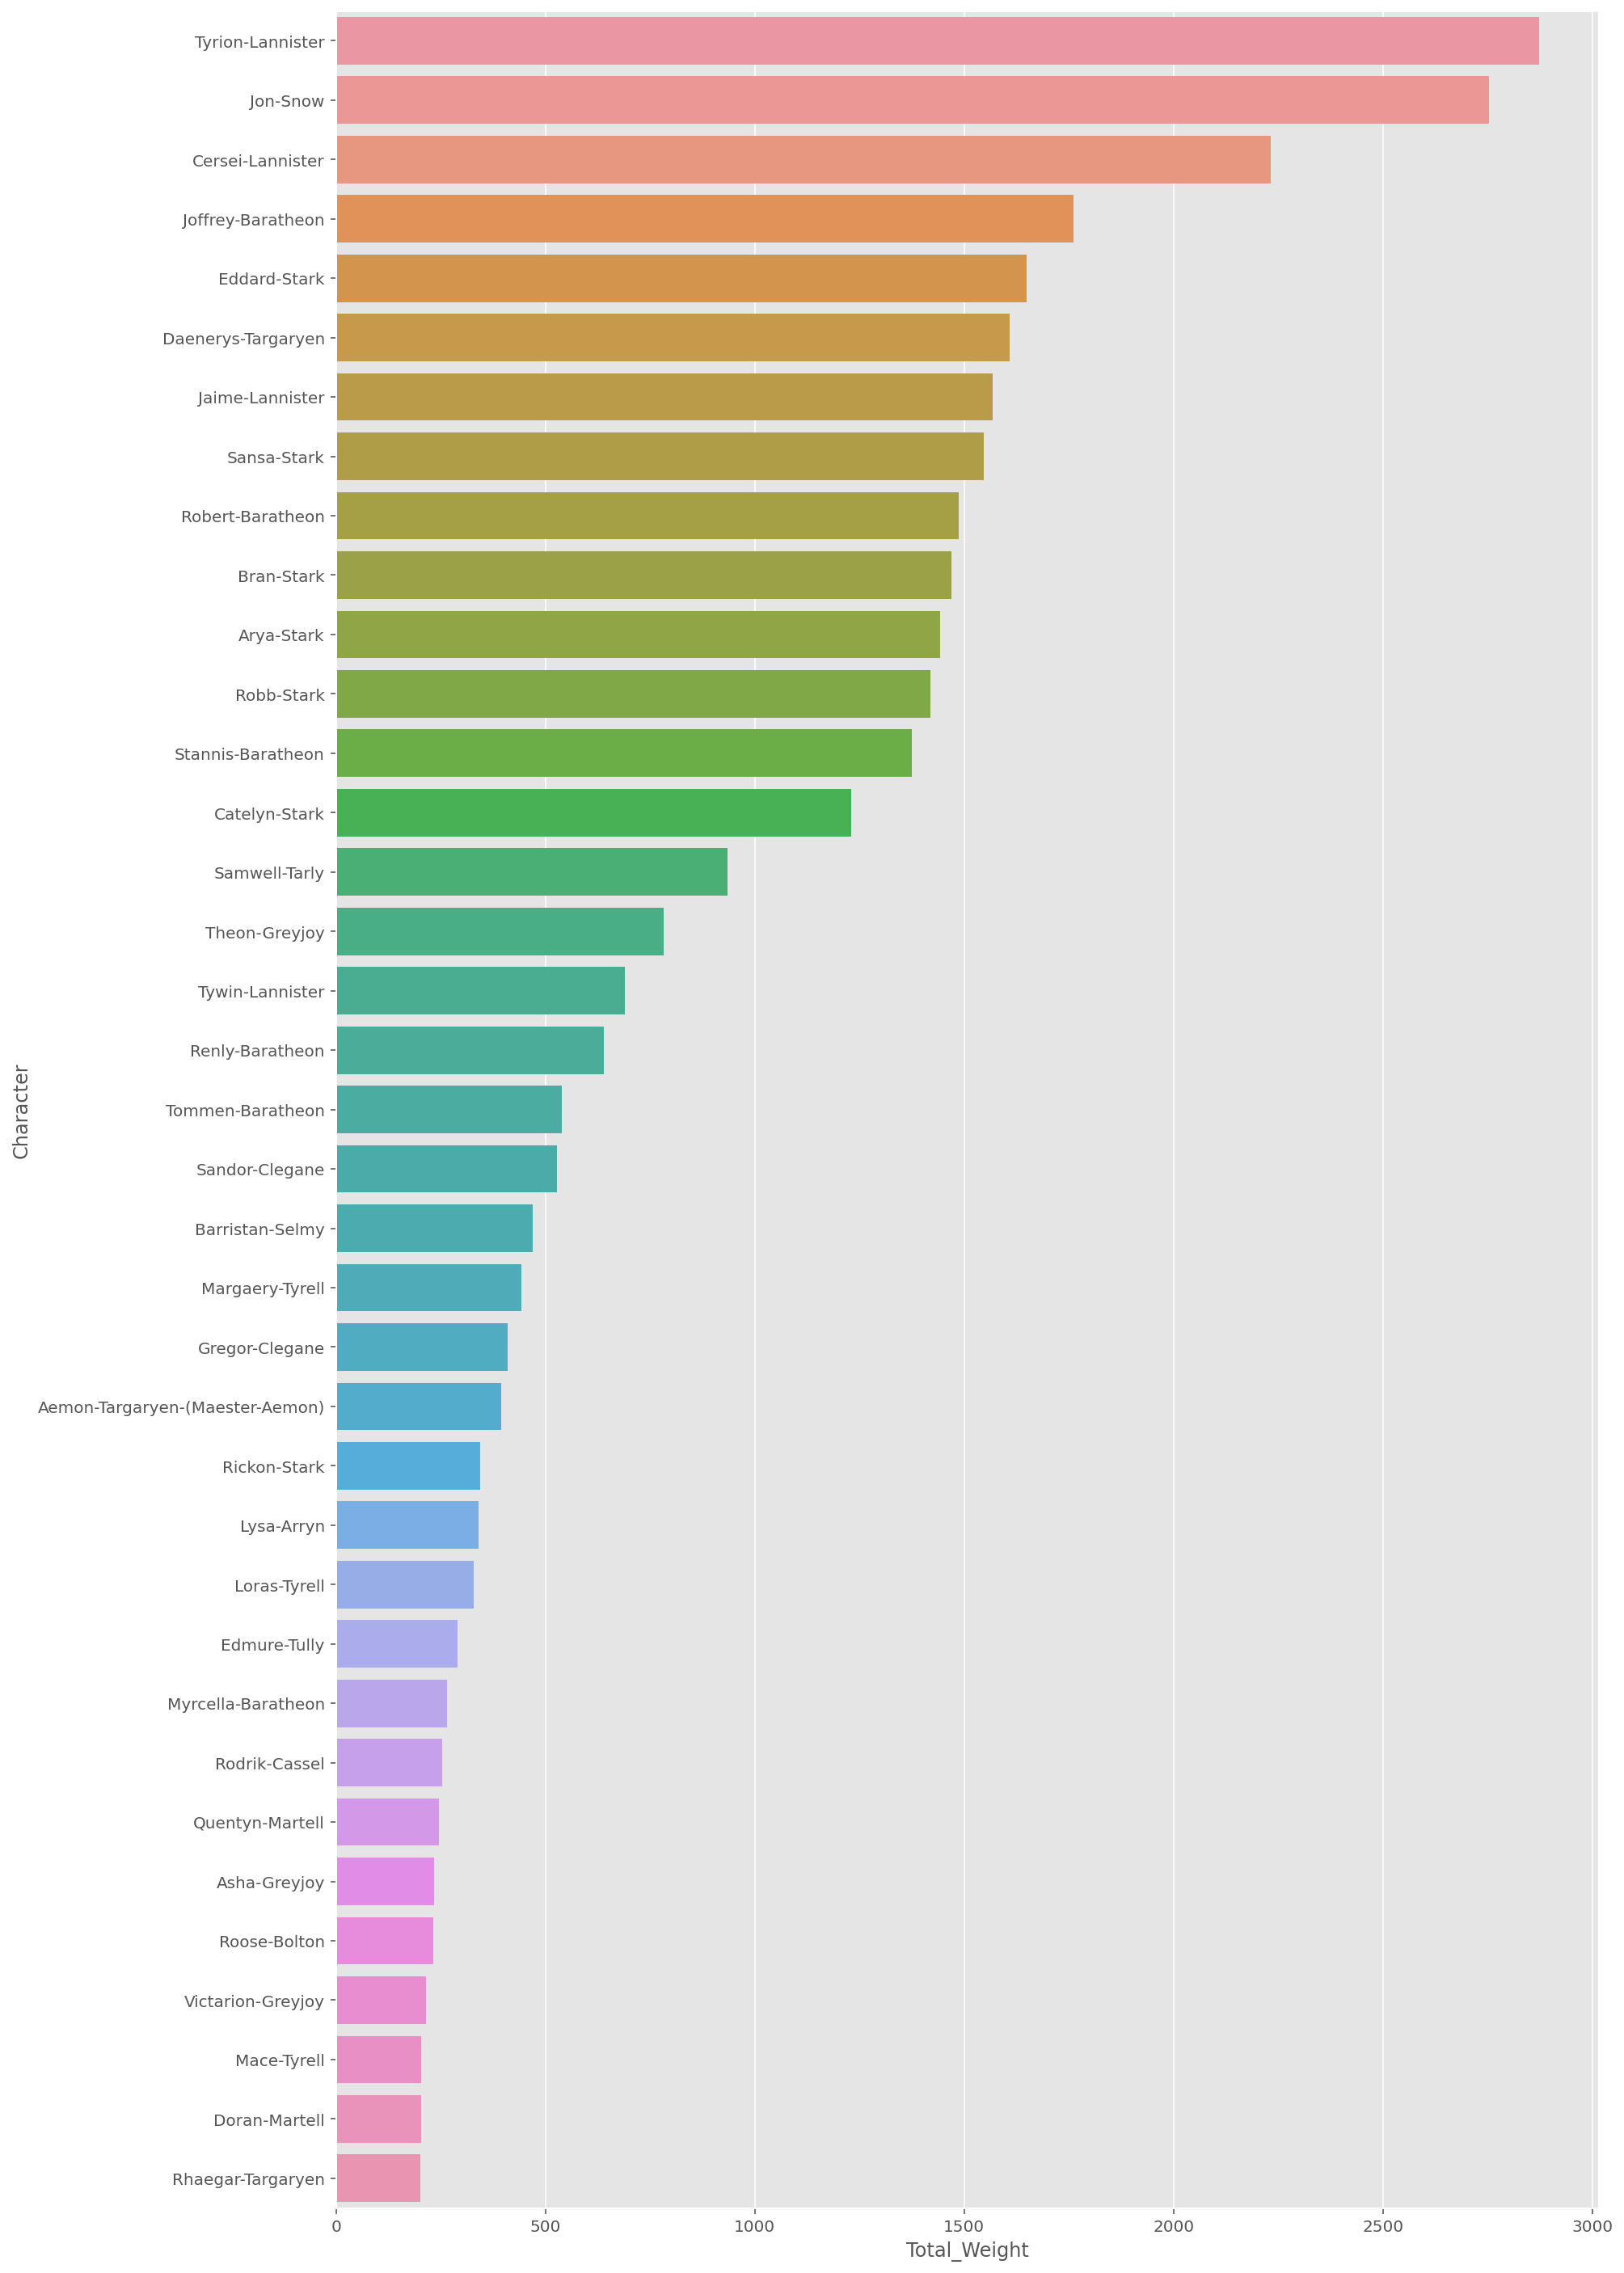

In [41]:
weight_frame = frame_filter(got_weight,'Total_Weight',200).sort_values(by='Total_Weight',ascending=False)
plt.figure(figsize = (14,25))
ax = sns.barplot(weight_frame.Total_Weight,weight_frame.Character)

In [42]:
got_nodes['Degree_Depth'] = got_nodes['Total_Weight'] / got_nodes['Degree']

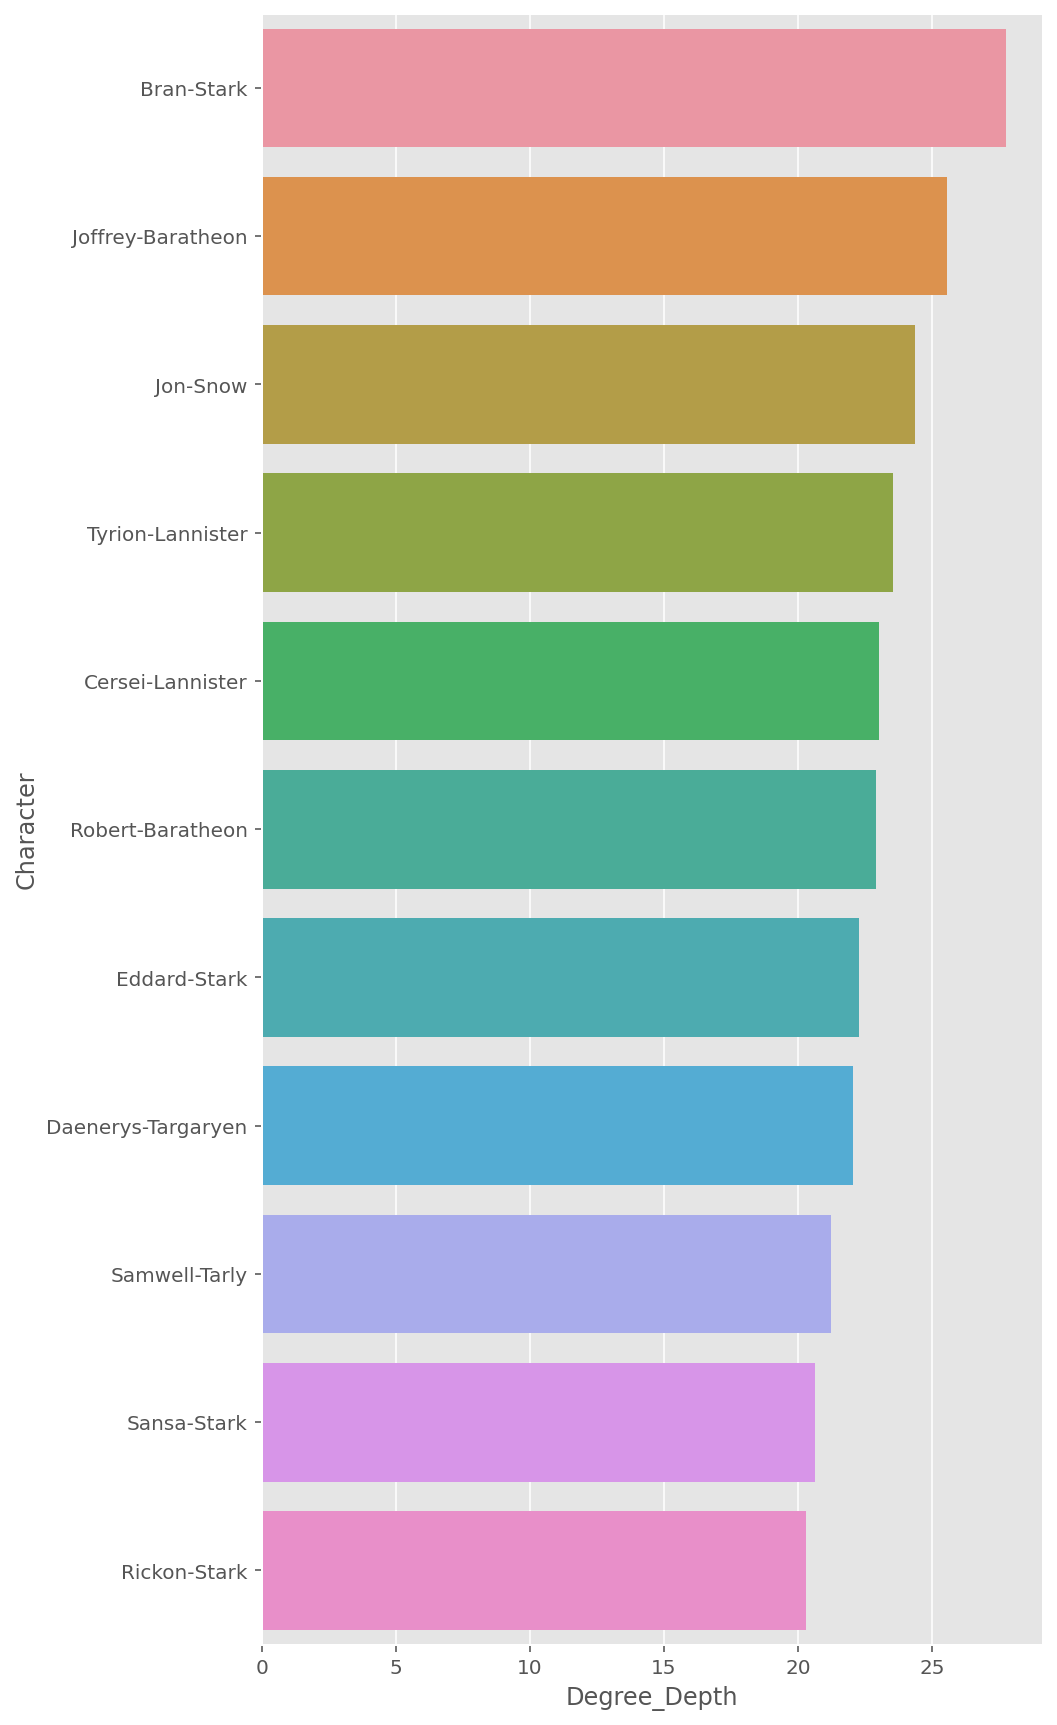

In [43]:
weight_frame = frame_filter(got_nodes.dropna(),'Degree_Depth',20).sort_values(by='Degree_Depth',ascending=False)
plt.figure(figsize = (7,15))
ax = sns.barplot(weight_frame.Degree_Depth,weight_frame.Character)